# Generative Advarsarial Network 

Here is presented the first GAN created by Ian Goodfellow https://arxiv.org/abs/1406.2661

Implementation is done in tensorflow

Created by: Tiago Almeida 02/02/2018

In [1]:
##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data MNIST

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


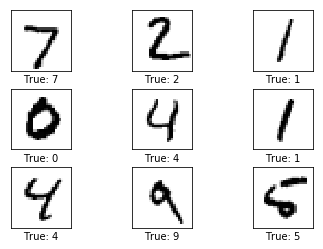

In [2]:
mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data")
ut.plot_mnist_images(mnist.test.images[0:9],cls_true=mnist.test.labels[0:9])

#reset graph using during notebook development
tf.reset_default_graph()



### Generator network 
In this implementation i use tensorflow layers API for creating the network

The network receive a 100-dimensinal vector (z) and return a 728-vector (same size of mnist image (28x28)). The objective is the generator create a mapping between space of vector z and the real MNIST DATA! (i think :P)

In [3]:
#array that contain the network dimention at least 2 dimention (input and output dimentions)
G_dimentions = [100,128,mnist_flat_size]

Z = tf.placeholder(tf.float32, shape=[None, G_dimentions[0]], name='x_generator_input')

def generator(x):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :return: tensor with shape (M,728) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.name_scope("generator_nn"):
        g_net = tf.layers.dense(x,G_dimentions[0],
                                    activation=tf.nn.relu,
                                    name='g_input', reuse=tf.AUTO_REUSE)
        for i in range(1,len(G_dimentions)-1):#loop throw hidden layers
            g_net = tf.layers.dense(g_net,G_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='g_hidden'+str(i),reuse=tf.AUTO_REUSE)
        g_net = tf.layers.dense(g_net,G_dimentions[-1],activation=tf.nn.sigmoid,name='g_output',reuse=tf.AUTO_REUSE)
        return g_net


### Discriminator network 
In this implementation i use tensorflow layers API for creating the network

The network receives a image (728 vector) and try classify as fake or original.

In [4]:
#array that contain the network dimention at least 2 dimention (input and output dimentions)
D_dimentions = [mnist_flat_size,128,1] ##ouput 1-fake, 0-true

X = tf.placeholder(tf.float32, shape=[None, D_dimentions[0]], name='x_discriminator_input')

def discriminator(x):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,728) here M = number of samples
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.name_scope("discriminator_nn"):
        d_net = tf.layers.dense(x,units=D_dimentions[0],
                                    activation=tf.nn.relu,
                                    name='d_input',reuse=tf.AUTO_REUSE)
        for i in range(1,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,D_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='d_hidden'+str(i),reuse=tf.AUTO_REUSE)
        d_net = tf.layers.dense(d_net,D_dimentions[-1],activation=None,name='d_output',reuse=tf.AUTO_REUSE)
        #save the logits before the sigmoid activation (ouput between[0,1])
        d_logits = d_net
        d_net = tf.nn.sigmoid(d_net)
        return d_net

### Loss functions Generator and Discriminator

Optimizers of tensorflow dont have maximizing method so we minimize the negative loss.

In [5]:

with tf.name_scope("generator_loss"): #D(G(Z))
    generated_sample = generator(Z)
    d_fake_prob = discriminator(generated_sample)
    g_loss = -tf.reduce_mean(tf.log(d_fake_prob))

with tf.name_scope("discriminator_loss"):
    d_true_prob = discriminator(X)
    d_loss = -tf.reduce_mean(tf.log(d_true_prob) + tf.log(1. - d_fake_prob))


#### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

Since we dont want to obtimize the discriminator when training de generator and vice-versa

In [6]:
#
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if 'd_' in var.name]

# kernel = weight
print(generator_variables)
print(discriminator_variables)



[<tf.Variable 'g_input/kernel:0' shape=(100, 100) dtype=float32_ref>, <tf.Variable 'g_input/bias:0' shape=(100,) dtype=float32_ref>, <tf.Variable 'g_hidden1/kernel:0' shape=(100, 128) dtype=float32_ref>, <tf.Variable 'g_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'g_output/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'g_output/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'd_input/kernel:0' shape=(784, 784) dtype=float32_ref>, <tf.Variable 'd_input/bias:0' shape=(784,) dtype=float32_ref>, <tf.Variable 'd_hidden1/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'd_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'd_output/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'd_output/bias:0' shape=(1,) dtype=float32_ref>]


### Training Algorithm


In [7]:
lr=0.0001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


def random_Z(m, n=100):
    '''
    Random values for Z between -1 and 1
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return np.random.uniform(-1., 1., size=[m, n])

## Start graph computations and algorithm


batch_size = 100
epoach = 10000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach):
    x_train,y_train = mnist.train.next_batch(batch_size)

    #first discriminator
    _, d_loss_value,d_sample = sess.run([d_train_op, d_loss, generated_sample], feed_dict={X: x_train, Z: random_Z(batch_size)})
    #second generator
    _, g_loss_value,g_sample = sess.run([g_train_op, g_loss,generated_sample], feed_dict={Z: random_Z(batch_size)})

    if i%100 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)

##After the otimization lets generate some numbers :D 

z_new = random_Z(9)

generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})


#ut.plot_mnist_images(generated_images,cls_true=[0]*9)


Discriminator loss:  1.35709
Generator loss: 1.11559
Discriminator loss:  0.0113126
Generator loss: 5.70228
Discriminator loss:  0.00649965
Generator loss: 6.34325
Discriminator loss:  0.006775
Generator loss: 6.10961
Discriminator loss:  0.0234811
Generator loss: 5.08756
Discriminator loss:  0.0466594
Generator loss: 5.60037
Discriminator loss:  0.0138109
Generator loss: 6.87439
Discriminator loss:  0.0150415
Generator loss: 6.85653
Discriminator loss:  0.00853939
Generator loss: 7.1002
Discriminator loss:  0.00549406
Generator loss: 7.55583
Discriminator loss:  0.000908314
Generator loss: 8.4563
Discriminator loss:  0.00208594
Generator loss: 8.06886
Discriminator loss:  0.00541286
Generator loss: 7.9515
Discriminator loss:  0.00180797
Generator loss: 8.39942
Discriminator loss:  0.00185618
Generator loss: 8.34344
Discriminator loss:  0.00062314
Generator loss: 8.5146
Discriminator loss:  0.000803236
Generator loss: 8.75479
Discriminator loss:  0.000559178
Generator loss: 9.08994
Dis

[[  6.07064898e-10   1.17725363e-09   2.03218864e-09 ...,   3.40285189e-10
    8.29469715e-10   7.38675010e-10]
 [  6.86043278e-10   1.46375012e-09   4.08920720e-09 ...,   1.78885984e-09
    1.90765959e-09   1.14466503e-09]
 [  1.02796776e-08   1.11372866e-08   1.74474426e-08 ...,   1.39900305e-08
    1.73608665e-08   1.35048328e-08]
 ..., 
 [  1.28614952e-09   1.80506454e-09   7.00406311e-09 ...,   2.06557704e-09
    2.98309533e-09   2.32569319e-09]
 [  9.77597114e-09   8.61213767e-09   1.33690250e-08 ...,   1.61782179e-08
    1.60849911e-08   9.05767461e-09]
 [  8.40253556e-09   1.01679998e-08   2.46277487e-08 ...,   8.79711948e-09
    1.48224286e-08   1.03982725e-08]]


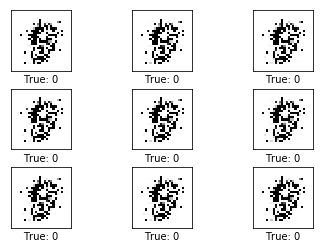

In [8]:


#generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})
print(generated_images)
ut.plot_mnist_images(generated_images,cls_true=[0]*9)
